In [1]:
# Preamble
from astropy.table import Table, column, vstack
import numpy as np
import os
import pandas as pd

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../../astro_codes/')

In [2]:
# Load the data
import pandas as pd
sparcfire_r = Table.read('../../sparcfire_directories/r/r.galaxy_matched.fits')
sparcfire_r_arcs = pd.read_csv('../../sparcfire_directories/r/r.galaxy_arcs.csv')

#### The checked images give us not only an opportunity to train our method for correctly identifying arcs, but also to help us decide which galaxies are reliable...

The first test that we can do is to use a binary method: which galaxies have 1+ well identified arcs, and do they change with galaxy inclination and redshift?

In [3]:
gz2_data = Table.read('../../fits/full_sample_debiased_w_low_z.fits')
inclinations = Table.read('../../fits/Axial_ratios/dr7_isoAB_matched.fits')
samples = Table.read('../../fits/sparcfire/sparcfire_samples.fits')

In [4]:
spiral_sample = np.all([samples['in_sparcfire'],samples['in_mass_limit'],
                        samples['in_spiral']],axis=0)

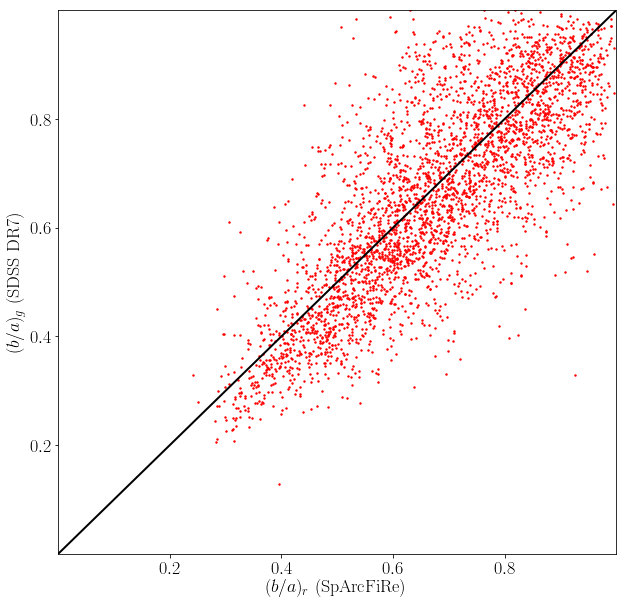

In [5]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

sparcfire_inclination = sparcfire_r['diskAxisRatio']
sdss_inclination = inclinations['isoB_g']/inclinations['isoA_g']
redshifts = gz2_data['REDSHIFT_1']

_ = ax.plot([0,1],[0,1],color='k',lw=2)
_ = plt.scatter(sparcfire_inclination[spiral_sample],
                sdss_inclination[spiral_sample],color='r',s=2)

_ = ax.set_xlabel('$(b/a)_r$ (SpArcFiRe)')
_ = ax.set_ylabel('$(b/a)_g$ (SDSS DR7)')
_ = ax.set_xlim(0,1)
_ = ax.set_ylim(0,1)

In [6]:
spotter_data = Table.read('../../SpiralSpotter/tables/spiral_spotter_sparcfire_data.fits')
spotter_subjects = Table.read('spotter_subjects_matched.fits')

ok_N_class = spotter_subjects['total'] >= 3

In [7]:
def measure_spotted_statistics(spotter_data):
    good_arc_columns = ['arc{}_good_frac'.format(i+1) for i in range(8)]
    good_arc_fracs = np.array([spotter_data[c] for c in good_arc_columns]).T
    good_arcs = good_arc_fracs >= 0.5
    N_good = np.sum(good_arcs,axis=1)
    return N_good

In [8]:
good_ids = spotter_subjects['dr8id'][ok_N_class]

sdss_inclination_subsample = []
sparcfire_inclination_subsample = []
redshift_subsample = []

for id_ in good_ids:
    mask_row = sparcfire_r['name'] == id_
    sdss_inclination_subsample.append(sdss_inclination[mask_row])
    sparcfire_inclination_subsample.append(sparcfire_inclination[mask_row])
    redshift_subsample.append(redshifts[mask_row])
#sparcfire_inclination_subsample = np.array(sparcfire_inclination_subsample)
#sdss_inclination_subsample = np.array(sdss_inclination_subsample)

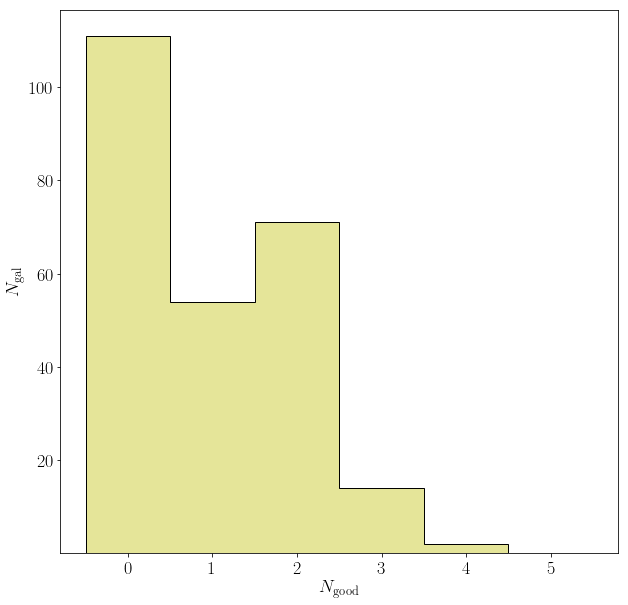

In [9]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

bins = np.linspace(-0.5,5.5,7)
n_good = measure_spotted_statistics(spotter_subjects[ok_N_class])
_ = ax.hist(n_good,bins,color='y',alpha=0.4)
_ = _ = ax.hist(n_good,bins,
                histtype='step',lw=1,color='k')

_ = ax.set_xlabel('$N_\mathrm{good}$')
_ = ax.set_ylabel('$N_\mathrm{gal}$')

Potential x values:
    
* inclination
* inclination 'error'
* redshift
* brightness?

In [10]:
good_galaxy_table = Table()
good_galaxy_table['dr8id'] = good_ids
good_galaxy_table['b/a (SDSS)'] = sdss_inclination_subsample
good_galaxy_table['b/a (sparcfire)'] = sparcfire_inclination_subsample 
good_galaxy_table['N_good'] = n_good
good_galaxy_table['1_good'] = good_galaxy_table['N_good'] >= 1
good_galaxy_table['delta_i'] = np.absolute(good_galaxy_table['b/a (SDSS)'] 
                                    - good_galaxy_table['b/a (sparcfire)'])
good_galaxy_table['redshift'] = redshift_subsample

In [11]:
from xy_plots import x_vs_y, assign_bins   

def x_vs_N_good(ax,galaxy_table,x_column,y_column='N_good',**kwargs):
    x_ = np.squeeze(np.array(galaxy_table[x_column]))
    y_ = np.squeeze(np.array(galaxy_table[y_column]))
    xy = x_vs_y(x_,y_)
    _ = xy.continuous_vs_continuous_binned(ax,bins=6,equal_N=True,
                                           **kwargs)
    _ = xy.show_spearmanr(ax,location='upper right')
    return None

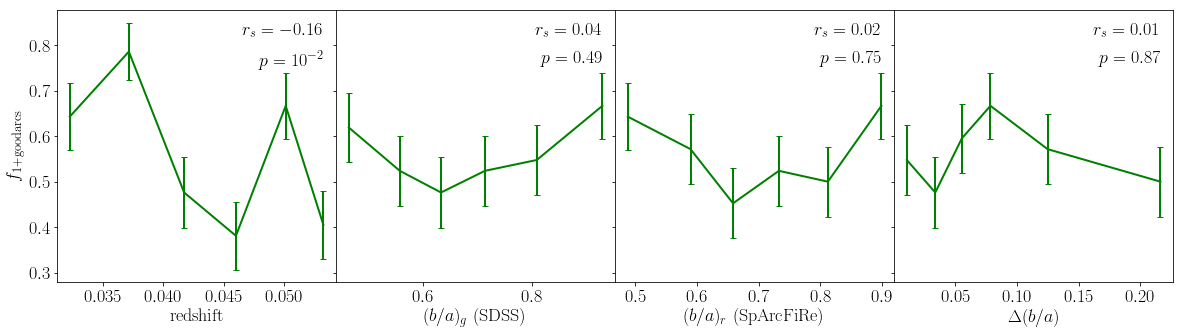

In [12]:
fig,axarr = plt.subplots(1,4,figsize=(20,5),sharey=True)
fig.subplots_adjust(hspace=0,wspace=0)

xlabel_list = ('redshift','$(b/a)_g$ (SDSS)','$(b/a)_r$ (SpArcFiRe)',
               '$\Delta (b/a)$')

for a, ax in enumerate(axarr):
    ax.set_xlabel(xlabel_list[a])
axarr[0].set_ylabel('$f_\mathrm{1+ good arcs}$')

x_vs_N_good(axarr[0],good_galaxy_table,'redshift','1_good',
            color='g',capsize=3,lw=2)
x_vs_N_good(axarr[1],good_galaxy_table,'b/a (SDSS)','1_good',
            color='g',capsize=3,lw=2)
x_vs_N_good(axarr[2],good_galaxy_table,'b/a (sparcfire)','1_good',
            color='g',capsize=3,lw=2)
x_vs_N_good(axarr[3],good_galaxy_table,'delta_i','1_good',
            color='g',capsize=3,lw=2)

#### Finally, check arm pitch angles and lengths w.r.t galaxy properties?

In [13]:
from arc_data import ArcData, ParamikoClient

arc_tables = []
for id_ in good_ids:
    arc_tables.append(ArcData(id_).arc_parameters(sparcfire_r_arcs,
                                                   sparcfire_r))
    
arc_table_spotted = vstack(arc_tables)

In [14]:
def make_comparison_array(ids,table,colname,absolute=False):
    array = np.ones((len(ids),8))*-999
    for i, id_ in enumerate(ids):
        masked_rows = table['gxyName'] == id_
        N_arcs = masked_rows.sum()
        masked_table = table[masked_rows]
        for n in range(N_arcs):
            if absolute is True:
                array[i,n] = np.absolute(masked_table[colname][n])
            else:
                array[i,n] = masked_table[colname][n]
    return array


def make_arc_mask(ids,table,suffix='good',p=0.5):
    array = np.full((len(ids),8),False,dtype=np.bool)
    for i, id_ in enumerate(ids):
        arc_row = table[table['dr8id'] ==  id_]
        arc_values = np.array([arc_row['arc{}_{}_frac'.format(c+1,suffix)] 
                               for c in range(8)])
        arc_boolean = arc_values >= p
        array[i,:] = np.squeeze(arc_boolean)
    return array


def make_value_array(ids,galaxy_table,colname,id_name='dr8id'):
    array = np.empty((len(ids),8))
    for i, id_ in enumerate(ids):
        galaxy_row = galaxy_table[galaxy_table[id_name] == id_]
        fill_value = galaxy_row[colname][0]
        row_array = np.full(8,fill_value,dtype=np.float32)
        array[i,:] = np.squeeze(row_array)
    return array

In [24]:
P_array = make_comparison_array(good_ids,arc_table_spotted,'pitch_angle',True)
L_array = make_comparison_array(good_ids,arc_table_spotted,'arc_length')
chi_array = make_comparison_array(good_ids,arc_table_spotted,'chirality_agreement')

mask_array = make_arc_mask(good_ids,spotter_subjects)

redshift_array = make_value_array(good_ids,good_galaxy_table,'redshift')
i_sdss_array = make_value_array(good_ids,good_galaxy_table,'b/a (SDSS)')
i_sparcfire_array = make_value_array(good_ids,good_galaxy_table,'b/a (sparcfire)')
i_error_array = make_value_array(good_ids,good_galaxy_table,'delta_i')

np.save('np_metadata/redshift_array.npy',redshift_array)
np.save('np_metadata/i_sdss_array.npy',i_sdss_array)
np.save('np_metadata/i_sparcfire_array.npy',i_sparcfire_array)
np.save('np_metadata/i_error_array.npy',i_error_array)
np.save('np_metadata/P_array.npy',P_array)
np.save('np_metadata/L_array.npy',L_array)
np.save('np_metadata/chi_array.npy',chi_array)
np.save('np_metadata/mask_array.npy',mask_array)

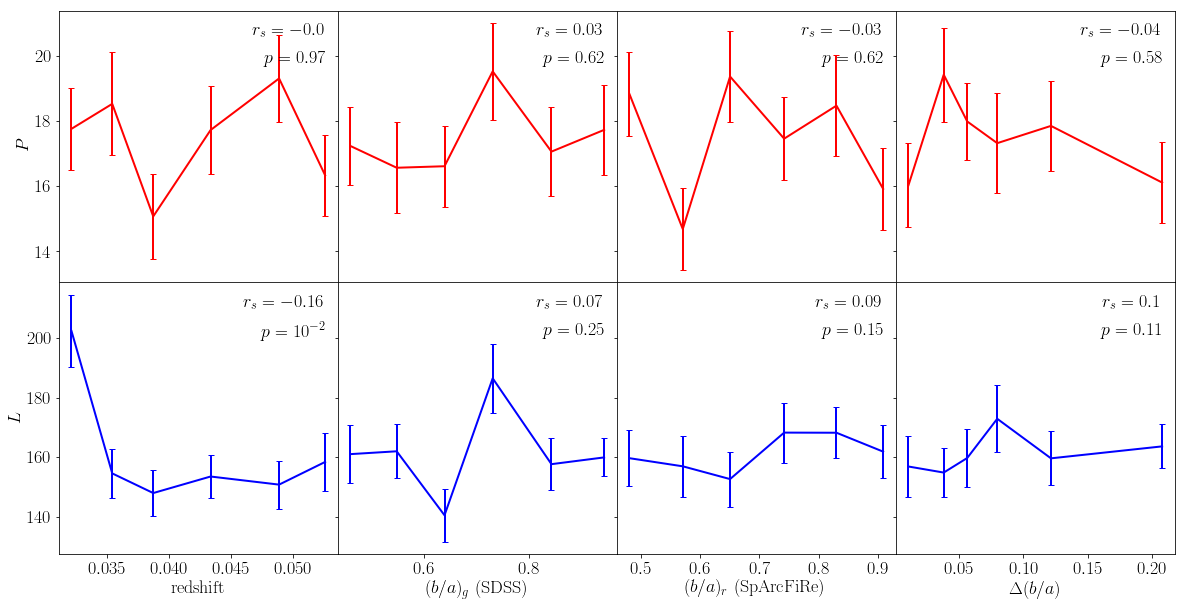

In [307]:
def xy_arrays_plot(ax,x_array,y_array,mask_array,**kwargs):
    x_ = x_array[mask_array].ravel()
    y_ = y_array[mask_array].ravel()
    xy = x_vs_y(x_,y_)
    _ = xy.continuous_vs_continuous_binned(ax,bins=6,equal_N=True,**kwargs)
    _ = xy.show_spearmanr(ax,location='upper right')
    return None

fig, axarr = plt.subplots(2,4,figsize=(20,10),sharex='col',sharey='row')
fig.subplots_adjust(hspace=0,wspace=0)

x_array_list = [redshift_array,i_sdss_array,i_sparcfire_array,i_error_array]
xlabel_list = ('redshift','$(b/a)_g$ (SDSS)','$(b/a)_r$ (SpArcFiRe)',
               '$\Delta (b/a)$')
#############################  
axarr0 = axarr[0]
axarr0[0].set_ylabel('$P$')

for ax, x_array, xlabel in zip(axarr0,x_array_list,xlabel_list):
    xy_arrays_plot(ax,x_array,P_array,mask_array,color='r',capsize=3,lw=2)
#############################  
axarr1 = axarr[1]
axarr1[0].set_ylabel('$L$')

for ax, x_array, xlabel in zip(axarr1,x_array_list,xlabel_list):
    xy_arrays_plot(ax,x_array,L_array,mask_array,color='b',capsize=3,lw=2)
    ax.set_xlabel(xlabel)

gxyName,alenRank,math_initial_theta,pitch_angle,math_initial_radius,relative_theta_start,relative_theta_end,r_start,r_end,used2rev,failed2rev,hasUndefinedEndpoints,arc_length,num_pixels,err_per_len,err_per_pixel,mean_intensity,brt_ratio_score,anovaF_score,clusOutputColor,chirality_agreement,pitch_angle_absolute,delta_r
object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,bool,object,object
1237661949727735904,1,7.37402,-14.705957000000001,56.680009999999996,0.0,1.919344,56.680009999999996,93.80005799999999,0,0,0,146.22337,2687.0,711.789965,38.734770000000005,0.42847700000000005,1.159727,369.38771,[1_0.9231_0],True,14.705957000000001,37.120048
1237661949727735904,2,4.8603559999999995,-12.338695,51.735714,0.0,1.917659,51.735714,78.698379,0,0,0,126.176428,1582.0,202.287777,16.133975,0.46343199999999996,1.059769,69.88533000000001,[1_0_0.9231],True,12.338695,26.962665
1237661949727735904,3,10.702247999999999,-14.802647,81.643699,0.0,0.919451,81.643699,104.09869599999999,0,0,0,87.889778,1275.0,109.63686399999999,7.557614999999999,0.313725,1.102757,194.402413,[0_1_0.7692],True,14.802647,22.45499699999999
1237661949727735904,4,7.312257000000001,-31.098985,22.120034,0.0,1.6639540000000002,22.120034,60.352654,0,0,0,74.019894,671.0,125.88988,13.887266,0.638478,1.03041,24.347742999999998,[0_1_0.3077],True,31.098985,38.23262
1237661949727735904,5,9.524746,20.611359,52.946785999999996,0.0,1.2220600000000001,33.437193,52.946785999999996,0,0,0,55.420694999999995,495.0,67.315702,7.536733,0.635417,1.030057,27.832931,[0.6154_1_0],False,20.611359,19.509592999999995
1237661949727735904,6,6.9505550000000005,40.303204,107.41188100000001,0.0,0.419433,75.258239,107.41188100000001,0,0,0,49.709384,493.0,57.000471999999995,5.747380000000001,0.315048,1.04912,9.163997,[0.6154_0_1],False,40.303204,32.153642000000005
1237661949727735904,7,10.723605000000001,-9.419994,30.822141,0.0,1.0534729999999999,30.822141,36.708648,0,0,0,35.965656,293.0,43.379127000000004,5.324774,0.685161,1.023291,40.374302,[0_0.7692_1],True,9.419994,5.886506999999998
1237661949727735904,8,12.257477,28.197956,134.35339199999999,0.0,0.223369,119.189494,134.35339199999999,0,0,0,32.091594,192.0,11.943029,1.996202,0.261418,1.1828379999999998,59.093577,[1_0_0.4615],False,28.197956,15.163897999999989
1237667536936894657,1,2.6112580000000003,-15.636080999999999,32.187936,0.0,3.7898339999999995,32.187936,92.972669,0,0,0,225.524304,3703.0,421.466492,25.66863,0.47858500000000004,1.193758,813.669362,[1_0_0.8571],True,15.636080999999999,60.784732999999996
